#Paris Gun Analysis
Russell Burns, Neeltje Kackar, Corey Martin, Paul,Dev Saxena

# Preamble

In [1]:
import IPython
import requests
import io
import numpy as np
import scipy as sp
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import math
import numpy.random as ran
import scipy.integrate as ig
import scipy.fftpack as fft
import scipy.io.wavfile as wf
from scipy.integrate import solve_ivp

In [2]:
def vsolve_rk4(f, t, q0):
    q0 = np.asarray(q0)
    t = np.asarray(t)
    q = np.zeros((len(t), len(q0)))
    q[0] = q0
    for i in range(0, len(t) - 1):
        h = t[i + 1] - t[i]
        k1 = h * f(q[i], t[i])
        k2 = h * f(q[i] + k1 / 2, t[i] + h / 2)
        k3 = h * f(q[i] + k2 / 2, t[i] + h / 2)
        k4 = h * f(q[i] + k3, t[i] + h)
        q[i + 1] = q[i] + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return q

#Abstract

<img src="http://upload.wikimedia.org/wikipedia/commons/e/e0/Parisgesch1.JPG" />

In this project we simulated the "Paris Gun" super-cannon:

http://en.wikipedia.org/wiki/Paris_Gun

Developed during the First World War, this massive piece of artillery was the first to ever fire projectiles into the stratoshphere ($h>10$km). We set out to analyze its firing angle, accuracy, and firing rate using 2D-drag ODEs and several statistical tools. In general, we found its military performance left a lot to be desired.

# Drag Modeling

The team wrote the function `kdrag(y)` that implements an approximation for the y coordinate dependent drag coefficient. This value is fed into the next function, `f2d_crag(q,t)`, which returns $q_{prime}$. Thus, `f2d_cdrag` can act as an input for either `vsolve_rk4(f, t, q0)` or `solve_ivp` to obtain accurate projectile motion in (x,y).

##Assumptions and Equations
###Altitude and Drag

Air density varies with altitude as so:
 $$ \rho(y) = \rho_0 \exp\left(-\frac{Mg}{R}\frac{y}{T_0-Ly}\right)$$
$M=2.9\times 10^{-2}~$kg/mol (molar mass of $N_2$), $g=9.8m/s^2$, $R=8.3~$J/mol K (ideal gas constant), $T_0=288~$K (chosen as temperature at $y_0=0$), and $L=6.5\times 10^{-3}~$K/m (per 1959 ARDC Model Atmosphere, valid up to 11km).

To simply the equation beyond L's altitude limit of 11km, the denominator in the exponetial is simply defined to be equal to its value at $y=10$km for $y>10$km.

Drag force is:

$$F_D = \frac{1}{2} \rho C_D A v^2$$

Here, $\rho_0=1.2kg/m^3$ ((molar mass of $N_2$), and $C_D=1/4$ (based on [form factor comparisons](https://www.researchgate.net/publication/235144241_Conceptual_Design_Approach_for_Small-Caliber_Aeroballistics_With_Application_to_556-mm_Ammunition/figures?lo=1/) between Paris Gun shells and $C_D$s of different bullets). $d_{shell}=216$mm.

###Further Assumptions
* $m_{shell}=106$kg. We neglected the effects of the corliolis force, earth's curvature, and wind.
* Nominal muzzle velocity $v_0 = 1640$m/s
* Barrel thickness $= 3cm$.
* Professor specified barrel thermal diffusivity $D= 1\times10^{-4} cm^2/sec$.

In [3]:
g = 9.8
def kdrag(y):
    r = 0.108
    c, rho0, m = 0.25, 1.2, 106
    M, R, T0, L = 2.9 * 10**-2, 8.3, 288, 6.5 * 10**-3
    A = math.pi * r**2
    if y <= 10000:
        rho = rho0 * np.exp((-(M * g * y) / (R * (T0 - (L * y)))))
        return c * rho * A / (2 * m)
    elif y >= 10000:
        rho = rho0 * np.exp((-(M * g * y) / (R * (T0 - (L * 10000)))))
        return c * rho * A / (2 * m)

In [4]:
def f2d_cdrag(q, t):
    qprime = np.zeros_like(q)
    y = q[2]
    v = np.sqrt(q[1] ** 2 + q[3] ** 2)
    qprime[0] = q[1]
    qprime[1] = -kdrag(y) * q[1] * v
    qprime[2] = q[3]
    qprime[3] = -kdrag(y) * q[3] * v - g
    return qprime

# Firing Function

Since $q_{prime}$ is produced by `f2d_crag`, the team simply needed to map that differential onto variables of interest for the Paris Gun. We wrote the function `shoot_gun(v0,theta0_deg, bool)` that takes in an initial velocity and angle and acts on them with $q_{prime}$. The function stops solving once y ≤ 0. By default, the function returns the projectile's range and its time of travel until it hits the ground. If the `bool` input is set to 1, you can also obtain the arrays that contain the height and range values throughout the launch.

In [5]:
def shoot_gun(v0, theta0_deg, bool):
    theta0 = math.radians(theta0_deg)
    vx0 = v0 * math.cos(theta0)
    vy0 = v0 * math.sin(theta0)
    x0, y0 = 0, 0
    q0 = [x0, vx0, y0, vy0]
    t0, tf = 0, 350
    t = np.linspace(t0, tf, 350)
    def landed(t, q):
        return q[2]
    landed.terminal = True
    landed.direction = -1
    def apogee(t, q):
        return q[3]
    apogee.direction = -1
    f2d_cdrag_rev = lambda t, q: f2d_cdrag(q, t)
    result_cdrag = solve_ivp(
        f2d_cdrag_rev,
        (t0, tf),
        q0,
        t_eval=t,
        dense_output=True,
        events=(landed, apogee),
    )

    clanded_events_t = result_cdrag.t_events[0]
    clanded_events_q = result_cdrag.y_events[0]

    capogee_events_t = result_cdrag.t_events[1]
    capogee_events_q = result_cdrag.y_events[1]
    if bool == 1:
        return clanded_events_t[0], clanded_events_q[0, 0], result_cdrag, capogee_events_q[0, 2], result_cdrag.y[0], result_cdrag.y[2]
    else:
        return clanded_events_t[0], clanded_events_q[0, 0], result_cdrag

# Firing Angle Optimization

The Paris Gun had a variable barrel angle. We were unable to find any information on the specific range of angles, but we were curious about how the gun's performance was affected by this one parameter. Metrics such as its maximum vertical and horzontal range have a strong relationship with it, so we plotted the correlation. One can also minimize the barrel angle for a fixed muzzle velocity and a target range, which we demonstrated on a target 95km away. We considered angles between zero and 90 degrees.

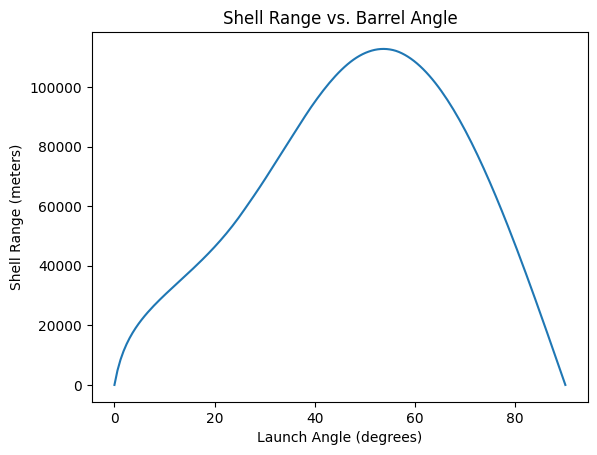

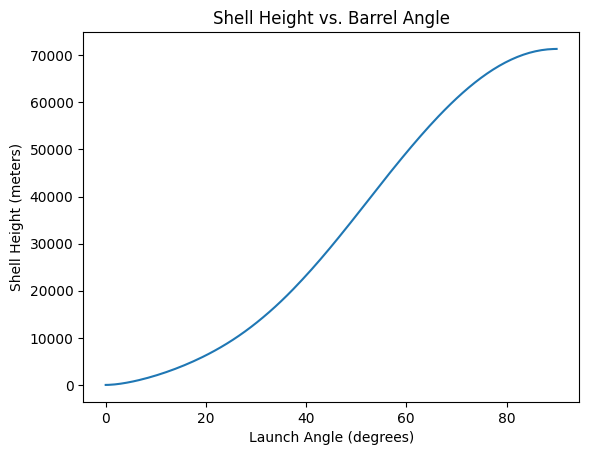

In [6]:
heights = []
ranges = []
max_range_angle = 0.0
max_range = 0.0
angle = np.linspace(0,90,150)

for i in angle:
    x= i
    result = shoot_gun(1640, i, 0)
    y = result[1]
    ranges.append(y)
    if y == max(ranges):
      max_range_angle = x
    if len(result[len(result) - 1]['y_events'][1]) > 0:
      heights.append(result[len(result) - 1]['y_events'][1][0][2])
    else:
      heights.append(0)


plt.plot(angle, ranges)
plt.title("Shell Range vs. Barrel Angle")
plt.xlabel("Launch Angle (degrees)")
plt.ylabel("Shell Range (meters)");
plt.figure()
plt.plot(angle, heights)
plt.title("Shell Height vs. Barrel Angle")
plt.xlabel("Launch Angle (degrees)")
plt.ylabel("Shell Height (meters)");

In [7]:
print(f"The maximum projectile distance is {max(ranges)} meters, achieved by a firing angle of {max_range_angle} degrees.")
print(f"The maximum projectile height is: {max(heights)} meters.")

The maximum projectile distance is 112814.31495959566 meters, achieved by a firing angle of 53.758389261744966 degrees.
The maximum projectile height is: 71342.89091253058 meters.


In [8]:
def target(i):
    dist = shoot_gun(1640, i, 0)[1]
    return abs(dist - 95000)

solutions = []
intervals = [(0,  max_range_angle), (max_range_angle, 90)]

for i in intervals:
    result = minimize_scalar(target, bounds=i, method='bounded')
    solutions.append(result.x)

print(f"The first optimal angle is {solutions[0]} degrees.")
print(f"The second optimal angle is {solutions[1]} degrees.")

The first optimal angle is 39.9731067130488 degrees.
The second optimal angle is 66.71921471911618 degrees.


# Varying Muzzle Velocity via a Rayleigh Distribution

The team decided to simulate random fluctuations in muzzle velocity at the optimal range angle as a way to judge the Paris Gun's accuracy. We are pulling random velocity values from a Rayleigh distribution, which is a type of distribution widely utilized in the field of ballistics. First, we initialized a RandomState object to create the bits for pseudo-random number generation. We then used the Rayleigh function to create a 10,000 element array that populates itself with the square root of twice a random number pulled from its distribution (using the memory alloted by us). We histogrammed the resulting random muzzle velocities and their ranges.

We specified muzzle velocities like so:

```python
random_v0=r.rayleigh(0.2,10000)*1640*0.1 + 1600
```

The mean is 113010.22026518537 meters.
The standard deviation is 2858.917402116047 meters.


Text(0.5, 1.0, 'Landing Position Bin Entry Counts')

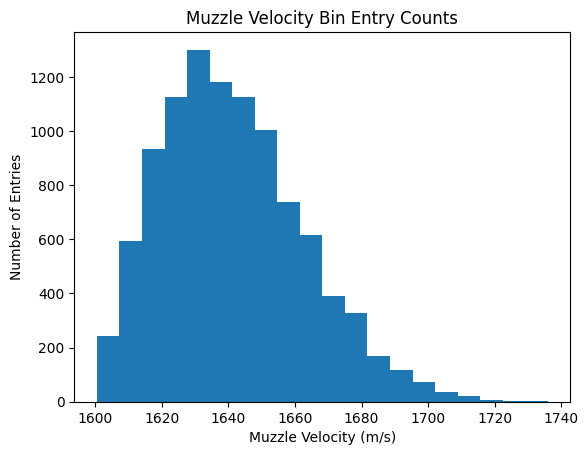

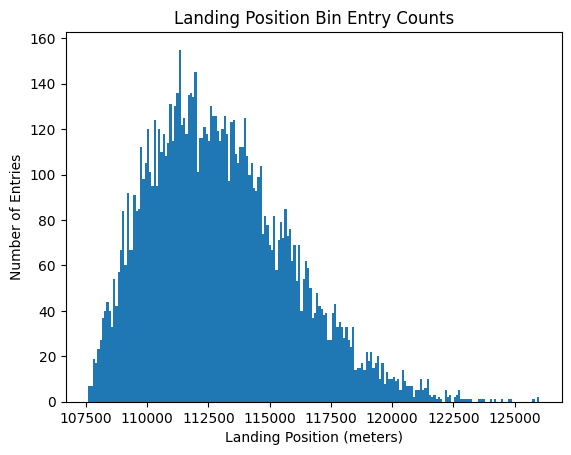

In [9]:
r = ran.RandomState()
random_v0 = r.rayleigh(0.2, 10000) * 1640 * 0.1 + 1600
plt.hist(random_v0, 20)
plt.xlabel("Muzzle Velocity (m/s)")
plt.ylabel("Number of Entries");
plt.title("Muzzle Velocity Bin Entry Counts")
landing_pos = []

for i in range(0, 10000):
    landing_pos.append(shoot_gun(random_v0[i], max_range_angle, 0)[1])
plt.figure()
plt.hist(landing_pos, 200)
print(f"The mean is {np.mean(landing_pos)} meters.")
print(f"The standard deviation is {np.std(landing_pos)} meters.")
plt.xlabel("Landing Position (meters)")
plt.ylabel("Number of Entries");
plt.title("Landing Position Bin Entry Counts")

For such a seemingly small range, the Paris Gun is neither accurate nor precise. For a mere 20m/s deviation from 1640m/s, the shell range shifts by as much as 2.5km (mile and a half). It would be useful for destruction of a city sized target, perhaps--Paris is 20km wide.

# Target Practice via FFT

The team decided to experiment with an audio encoding scheme to obtain an audio file, `group1.wav`, that contains a hidden message with a target range. We did an FFT on the .wav, later inverting it with an IFFT to obtain the target distance. We then plotting the trajectory of your shot.

An FFT returns a list of 64-bit real numbers and 128-bit complex numbers, but a `.wav` format uses 16-bit signed integers (maximum = $2^{15} -1 = 32767$). So, we needed to convert all `.wav` output to 16-bits via

```python
output = np.int16(iFFTwav/np.max(np.abs(iFFTwav)) * 32767)

```
We also disregarded any complex outputs.

Length of waveform: 55405
Sampling rate: 22050 Hz


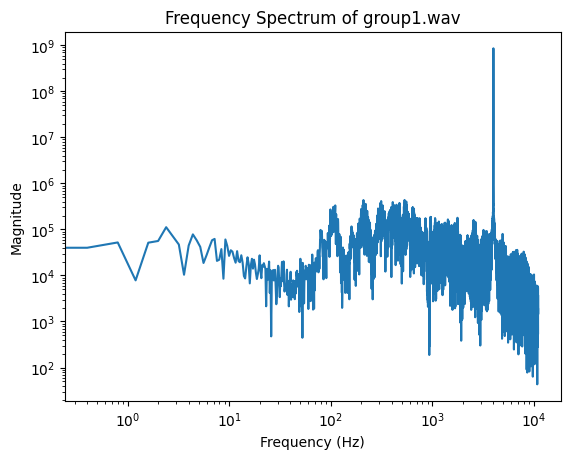

In [21]:
f = io.BytesIO(
    requests.get(
        "https://gist.github.com/Theelx/19cebf1151da1abe68afbaa174df5de0/raw/a409606a761647fede876cc34b06f73f97ff76db/group4.wav"
    ).content
)
samples_per_sec, wav_data = wf.read(f)
t = np.linspace(0, len(wav_data) / samples_per_sec, len(wav_data))
print("Length of waveform:", len(wav_data))
print("Sampling rate:", samples_per_sec, "Hz")

FFTwav = fft.fft(wav_data)
N = len(wav_data)
freqs = fft.fftfreq(N, 1 / samples_per_sec)
plt.loglog(np.abs(freqs[0 : N // 2 + 1]), np.abs(FFTwav[0 : N // 2 + 1]));
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude");
plt.title("Frequency Spectrum of group1.wav");

In [11]:
def low_pass(Fks, freqs, f0):
    result = np.zeros_like(Fks)
    for i, f in enumerate(freqs):
        if math.fabs(f) < math.fabs(f0):
            result[i] = Fks[i]
            # otherwise result[i]=0
    return result

def high_pass(Fks, freqs, f0):
    result = np.zeros_like(Fks)
    for i, f in enumerate(freqs):
        if math.fabs(f) > math.fabs(f0):
            result[i] = Fks[i]
            # otherwise result[i]=0
    return result

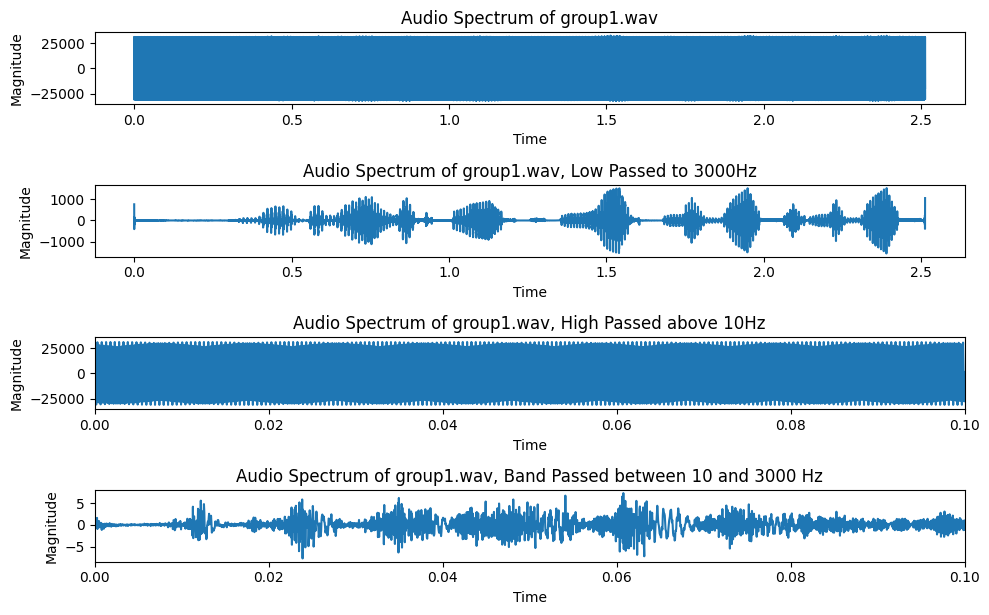

In [23]:
iFFTwav = fft.ifft(FFTwav)

plt.figure(figsize=(10, 10 / 1.6))
plt.subplot(411)
plt.plot(t, iFFTwav)
plt.xlabel("Time")
plt.ylabel("Magnitude");
plt.title("Audio Spectrum of group1.wav");
plt.tight_layout()

plt.subplot(412)
iFFTwav_low = fft.ifft(low_pass(FFTwav, freqs, 3000))
# iFFTwav_low = 100 * iFFTwav_low
plt.plot(t, iFFTwav_low)
plt.xlabel("Time")
plt.ylabel("Magnitude");
plt.title("Audio Spectrum of group1.wav, Low Passed to 3000Hz");
plt.tight_layout()

plt.subplot(413)
iFFTwav_high = fft.ifft(high_pass(FFTwav, freqs, 10))
plt.plot(t, iFFTwav_high)
plt.xlim(0, 0.1)
plt.xlabel("Time")
plt.ylabel("Magnitude");
plt.title("Audio Spectrum of group1.wav, High Passed above 10Hz");
plt.tight_layout()

plt.subplot(414)
iFFTwav_both = fft.ifft(high_pass(iFFTwav_low, freqs, 10))
plt.plot(t, iFFTwav_both)
plt.xlim(0, 0.1);
plt.xlabel("Time")
plt.ylabel("Magnitude");
plt.title("Audio Spectrum of group1.wav, Band Passed between 10 and 3000 Hz");
plt.tight_layout()
plt.tight_layout()

It is clear that the low pass filtered option has the most audible and coherent waveform, so we looked there first for the hidden message. We got lucky!

In [13]:
iFFTwav_low_real = np.real(iFFTwav_low)
print(iFFTwav_low_real)

[ 769.68807551  286.87938449 -168.00529974 ...  703.6409407  1038.54013405
 1065.43389081]


In [14]:
# multiply by 4 to quadruple the volume, makes it more audible
output = iFFTwav_low_real.astype(np.int16) * 4
flipped = np.flip(output)
wf.write("target.wav", 22050, flipped)

In [15]:
IPython.display.Audio('target.wav')

In [16]:
# The encoded message is: 77.2 kilometers

In [17]:
def target(i):
    dist = shoot_gun(1640, i, 0)[1]
    return abs(dist - 77200)

solutions = []
intervals = [(0,  max_range_angle), (max_range_angle, 90)]

for i in intervals:
    result = minimize_scalar(target, bounds=i, method='bounded')
    solutions.append(result.x)

print(f"The first optimal angle is {solutions[0]} degrees")
print(f"The second optimal angle is {solutions[1]} degrees")

The first optimal angle is 33.12983591556746 degrees
The second optimal angle is 72.4607911837474 degrees


The ball landed at x=77200.00 m 
It reached a height of y=15931.66 m 
It landed 113.78 seconds after it was thrown
The ball landed at x=77200.00 m 
It reached a height of y=63132.86 m 
It landed 227.32 seconds after it was thrown


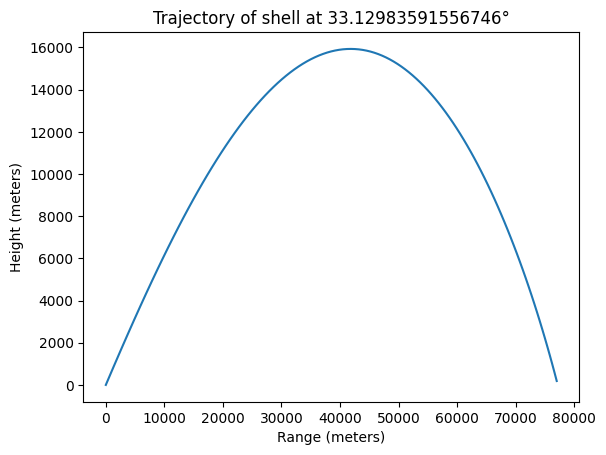

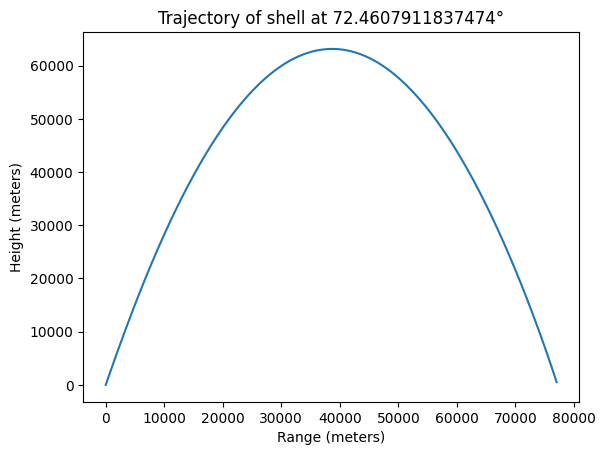

<Figure size 640x480 with 0 Axes>

In [18]:
for i in solutions:
    results = shoot_gun(1640, i, 1)
    print("The ball landed at x=%.2f m "%(results[1]))
    print("It reached a height of y=%.2f m "%(results[3]))
    print("It landed %.2f seconds after it was thrown"%(results[0]))
    plt.plot(results[4],results[5])
    plt.xlabel("Range (meters)")
    plt.ylabel("Height (meters)")
    plt.title(f"Trajectory of shell at {i}°")
    plt.figure()

# Fire Rate Analysis via FCTS Heat Modeling

Artillery cooldown periods are an extremely informative metric. We were curious about how the Paris Gun would have endured a high firing rate--it was only fired about twenty times a day, but we wanted to push its limits. We used an FCTS method to track the heat conduction along a one-dimensional, radial slice of the barrel (since it is symmetric). We required some initial conditions:
* Assume a firing rate of 6 times a minute
* Suppose the inner and outer surface are held at 0 C
* Suppose upon firing when the gun fires the inner 0.5 cm heats up to 200 C.

After each shot we showed the temperature distribution as a function of the radius across 1 second.

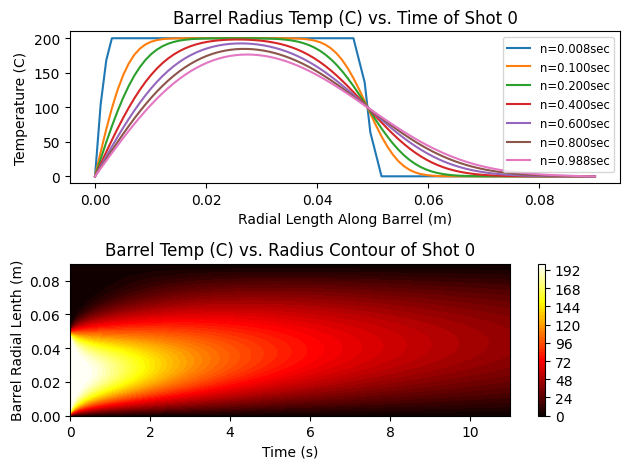

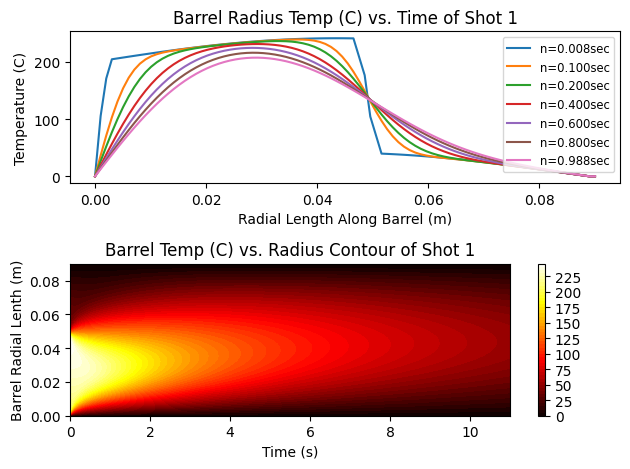

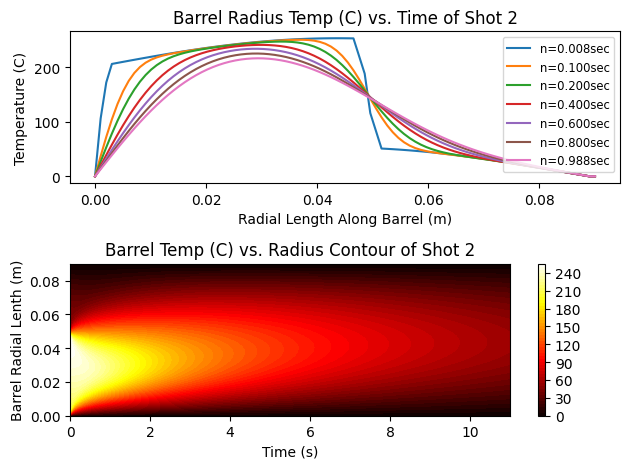

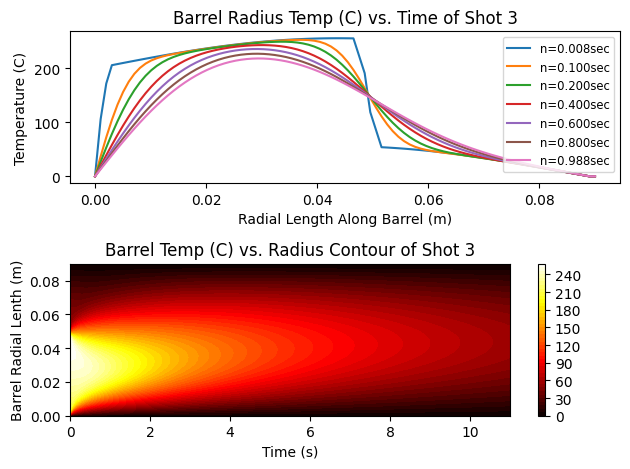

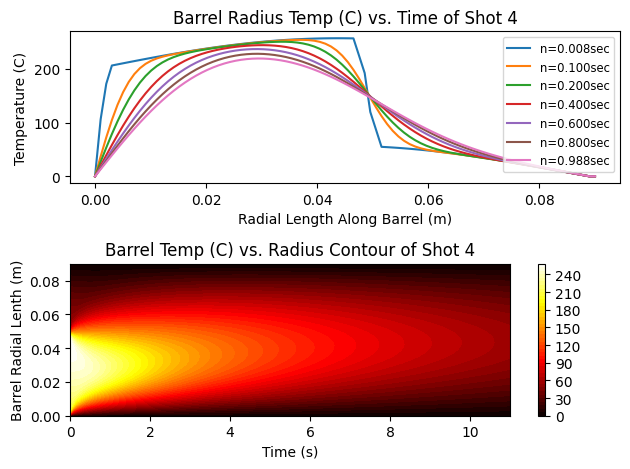

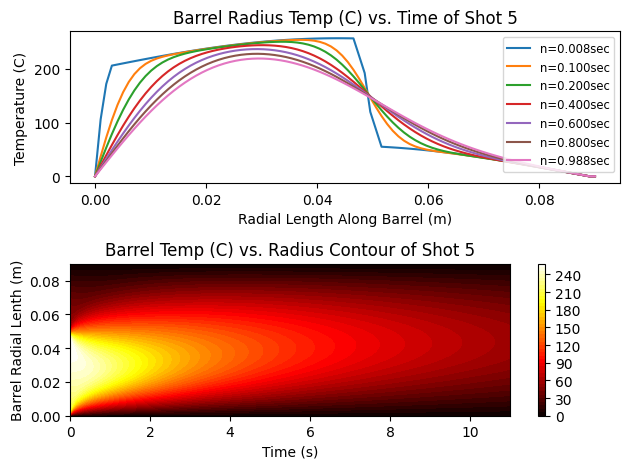

In [31]:
# numerical constant here and initial condition
L = .09 # thickness of bar (m)
J = 90  # number of spatial slices (grid points)
N = 2500  # number of time slices
D = 1e-4 #m^2/s # Coefficient suggested by professor
duration = 10  # seconds
dt = duration / N  # delta t
dx = L / J  # delta x
# setup a 2d grid with the x and t points
t, x = np.mgrid[0 : duration + 1 : N * 1j, 0 : L : J * 1j]

# variable to hold the value of u
# the whole bar starts at 0 degrees
u = np.zeros_like(x)
def shoot_once(u):
    u[:, 0:int((.05/L)*(J-1))] += 200
    u[:, 0] = 0
    u[:, J-1] = 0

    for n in range(0, N - 1):
        for j in range(1, J - 2):
            u[n + 1, j] = (D * dt / (dx**2)) * (
                u[n, j + 1] - 2 * u[n, j] + u[n, j - 1]
            ) + u[n, j]
    return u

def draw_graphs(i):
    fig, axs = plt.subplots(2)
    tsteps = list(map(int, [.001*N, .01*N, .02*N, .04*N, .06*N, .08*N, .099*N]))
    for n in tsteps:
        axs[0].plot(x[n, :], u[n, :], label="n=%.3fsec" % (n*duration/N))

    axs[0].legend(fontsize="small")
    axs[0].set_xlabel("Radial Length Along Barrel (m)")
    axs[0].set_ylabel("Temperature (C)")
    axs[0].set_title(f"Barrel Radius Temp (C) vs. Time of Shot {i}")

    cs = axs[1].contourf(t, x, u, 50, cmap='hot')
    fig.colorbar(cs, ax=axs[1])
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Barrel Radial Lenth (m)")
    axs[1].set_title(f"Barrel Temp (C) vs. Radius Contour of Shot {i}")
    plt.tight_layout()
    plt.show()

for i in range(6):
    u = shoot_once(u)
    draw_graphs(i)
    final_state = u[int(.999*N), :]
    u = np.zeros_like(x)
    u[0, :] = final_state



The provided diffusion coefficient is closer to that of bricks than it is of copper. The sim breaks with real coefficient of steel is used--.018. Steel melts from 1300-1500 C, a firing rate much higher than 20 a day is likely to cause problems.